In [2]:
import os
import csv
import pandas as pd
import skimage
from skimage.transform import resize
import skimage.io as io
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms

import numpy as np
import matplotlib.pyplot as plt

In [3]:
torch.cuda.is_available()

True

In [109]:
# params: conv_layers: a list of lists, containing the number of channels out[0], kernel size[1] and padding size[2]
#         pool_layers: a list of lists, each list contains the patch size[0] and stride [1]
#         fc_layers: a single list containing the number of hidden units in each layer
#         loss_crit: the loss criterion for the network - suggested BCE Loss
#         batch_norm: a boolean if True, adds batchnorm to every layer
class NeuralNet(nn.Module):
    def __init__(self, order,conv_layer,pool_layers,fc_layers,loss_crit,dropout=0.5,batch_norm=False):
        super(NeuralNet,self).__init__()
        self.loss_crit = loss_crit
        self.cuda_available = False#torch.cuda.is_available()
        conv_ind=0
        pool_ind = 0
        affine_ind = 0
        curr_ind = 0
        self.layers = []
        self.myparameters = []

        for i in range(len(order)):
            if (i==0):
                if (order[i] == 'conv'):
                    self.layers.append(nn.Conv2d(in_channels=3, out_channels=conv_layer[0][0],
                                      kernel_size=(conv_layer[0][1],conv_layer[0][1]),
                                      padding=conv_layer[0][2]))
                    curr_ind +=1
                    torch.nn.init.xavier_normal(self.layers[-1].weight)
                    torch.nn.init.constant(self.layers[-1].bias,0)
                    self.myparameters.append(self.layers[-1].weight)
                    self.myparameters.append(self.layers[-1].bias)
                    if dropout != 0:
                        self.layers.append(nn.Dropout2d(dropout))
                        curr_ind +=1
                    if (batch_norm):
                        self.layers.append(nn.BatchNorm2d(conv_layer[0][0]))
                        curr_ind +=1
                        if (self.cuda_available):
                            self.layers[-1].running_mean = self.layers[-1].running_mean.cuda()
                            self.layers[-1].running_var = self.layers[-1].running_var.cuda()
                    self.layers.append(nn.ReLU())
                    curr_ind +=1
                    outsize = (64-conv_layer[0][1]+2*conv_layer[0][2])/1 + 1
                    conv_ind+=1
                    
                    

            else:
                if (order[i] == 'conv'):
                    self.layers.append(nn.Conv2d(in_channels=conv_layer[conv_ind-1][0], 
                                                out_channels=conv_layer[conv_ind][0],
                                                kernel_size=(conv_layer[conv_ind][1],conv_layer[conv_ind][1]),
                                                padding=conv_layer[conv_ind][2]))
                    torch.nn.init.xavier_normal(self.layers[-1].weight)
                    torch.nn.init.constant(self.layers[-1].bias,0)
                    
                    self.myparameters.append(self.layers[-1].weight)
                    self.myparameters.append(self.layers[-1].bias)
                    curr_ind += 1
                    
                    if dropout != 0:
                        self.layers.append(nn.Dropout2d(dropout))
                        curr_ind += 1
                    if (batch_norm):
                        self.layers.append(nn.BatchNorm2d(conv_layer[conv_ind][0]))
                        self.myparameters.append(self.layers[-1].weight)
                        self.myparameters.append(self.layers[-1].bias)
                        curr_ind += 1
                        if (self.cuda_available):
                            self.layers[-1].running_mean = self.layers[-1].running_mean.cuda()
                            self.layers[-1].running_var = self.layers[-1].running_var.cuda()

                    self.layers.append(nn.ReLU())
                    curr_ind +=1
                    outsize = (outsize-conv_layer[conv_ind][1]+2*conv_layer[conv_ind][2])/1 + 1
                    conv_ind += 1
                
                if (order[i] == 'affine'):
                    if affine_ind == 0:
                        self.first_affine_ind = curr_ind
                        self.conv_outsize = int(outsize*outsize*conv_layers[-1][0])
                        self.layers.append(nn.Linear(self.conv_outsize,fc_layers[0]))
                        curr_ind +=1
                    else:
                        self.layers.append(nn.Linear(fc_layers[affine_ind-1],fc_layers[affine_ind]))
                        curr_ind +=1
                    torch.nn.init.xavier_normal(self.layers[-1].weight)
                    torch.nn.init.constant(self.layers[-1].bias,0)
                    self.myparameters.append(self.layers[-1].weight)
                    self.myparameters.append(self.layers[-1].bias)
                    if dropout != 0 and affine_ind != len(fc_layers)-1:
                        self.layers.append((nn.Dropout(dropout)))
                        curr_ind +=1
                    if (batch_norm):
                        self.layers.append(nn.BatchNorm1d(fc_layers[affine_ind]))
                        self.myparameters.append(self.layers[-1].weight)
                        self.myparameters.append(self.layers[-1].bias)
                        curr_ind +=1
                        if self.cuda_available:
                            self.layers[-1].running_mean = self.layers[-1].running_mean.cuda()
                            self.layers[-1].running_var = self.layers[-1].running_var.cuda()
                    if (affine_ind != len(fc_layers)-1):
                        self.layers.append(nn.ReLU())
                        curr_ind +=1
                    affine_ind += 1
                    
                if (order[i] == 'pool'):
                    self.layers.append(nn.MaxPool2d(kernel_size=(pool_layers[pool_ind][0],pool_layers[pool_ind][0]),
                                                    stride=pool_layers[pool_ind][1]))
                    outsize = (outsize-pool_layers[pool_ind][0])/pool_layers[pool_ind][1]+1
                    pool_ind += 1
                    curr_ind +=1
        
        
        self.myparameters = nn.ParameterList(self.myparameters)

    def print_types(self):
        for layer in self.conv_layers:
            print(type(layer[0].weight))
    def forward(self,x):
        layer_input = x
        for i in range(len(self.layers)):

            if i== self.first_affine_ind:
                layer_input = layer_input.view((-1,self.conv_outsize))
                layer_input = self.layers[i](layer_input)
            else:
                layer_input = self.layers[i](layer_input)
        return layer_input
    
    def evaluate_model(self,loader):
        correct = 0
        total = 0
        for batch_index,(batch) in enumerate(loader):
            inputs = batch['image']
            targets = batch['label']
            if self.cuda_available:
                inputs = inputs.cuda()
                targets = targets.cuda()
            x, targets = Variable(inputs.view([-1,3,64,64])).float(), Variable(targets)

            logits = self.forward(x)
            preds = self.prediction(logits)
            correct += preds.eq(targets.data.int()).sum()
            total += targets.size(0)
        accuracy = (correct/float(total))
        return accuracy
    
    def prediction(self,logits):
        
        _,preds = torch.max(logits.data,1)
        preds = preds.squeeze()
        preds = preds.int()
        return preds

    def train_model(self, train_data,optimizer,batch_size, num_epochs,early_stopping=False, val_split = 0, test_data = None, verbose=True ):

        train_loader, val_loader, test_loader = make_data_loaders(train_data,batch_size,val_split,test_data)
        
        bestValAcc = 0
        bestNetwork = 0
        train_accuracy = []
        val_accuracy = []
        test_accuracy = []
        epoch_loss=[]

        for epoch in range(num_epochs):
            losses = []
            correct = 0
            total = 0
            val_correct = 0
            val_total = 0
            test_correct = 0
            test_total = 0

            for index, batch in enumerate(train_loader):
                inputs = batch['image']
                targets = batch['label']
                if self.cuda_available:
                    inputs = inputs.cuda()
                    targets = targets.cuda()
                inputs = Variable(inputs.view([-1,3,64,64])).float()
                targets = Variable(targets)
                optimizer.zero_grad()
                logits = self.forward(inputs)
                preds = self.prediction(logits)
                correct += preds.eq(targets.data.int()).sum()
                total += targets.size(0)
                loss = self.loss_crit(logits,targets)
                
                loss.backward()
                optimizer.step()
                losses.append(loss.data[0])
            epoch_loss.append(np.mean(losses))
            train_accuracy.append(correct/float(total))
            
            if (val_loader != None):
                val_acc = self.evaluate_model(val_loader)
                val_accuracy.append(val_acc)
                            
                if val_acc > bestValAcc:
                    bestNetwork = self
                    bestValAcc= val_acc
                
                if (early_stopping and val_acc < bestValAcc) :
                    return bestNetwork
            
            if (test_loader != None):
                test_acc = self.evaluate_model(test_loader)
                test_accuracy.append(test_acc)
            
            if (val_loader != None and test_loader != None and verbose == True):
                print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f Validation Accuracy: %.3f Test Accuracy: %.3f' % (epoch+1,epoch_loss[epoch],\
                                                                                                                  train_accuracy[epoch], val_accuracy[epoch], test_accuracy[epoch]))
            elif (val_loader != None and test_loader == None and verbose == True):
                print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f Validation Accuracy: %.3f' % (epoch+1,epoch_loss[epoch],\
                                                                                              train_accuracy[epoch], val_accuracy[epoch]))
            elif (verbose == True):
                print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f' %(epoch+1, epoch_loss[epoch], train_accuracy[epoch]))
        return (bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy)
    


In [86]:
order = ['conv','pool','conv','pool','affine','affine']
conv_layers = [[16,3,1],[32,3,1]]
pool_layers = [[2,2],[2,2]]
affine_layers = [1000,2]
#self, order,conv_layer,pool_layers,fc_layers,loss_crit,dropout=0.5,batch_norm=False)
model = NeuralNet(order,conv_layers,pool_layers,affine_layers,nn.CrossEntropyLoss(),dropout=0.5)
x = torch.Tensor(5,3,64,64).uniform_(0,1)
for layer in model.layers:
    print(layer)
x = Variable(x)
model.forward(x)

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Dropout2d(p=0.5)
ReLU()
MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Dropout2d(p=0.5)
ReLU()
MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
Linear(in_features=8192, out_features=1000, bias=True)
Dropout(p=0.5)
ReLU()
Linear(in_features=1000, out_features=2, bias=True)
0
Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1
Dropout2d(p=0.5)
2
ReLU()
3
MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
4
Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
5
Dropout2d(p=0.5)
6
ReLU()
7
MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
8
Linear(in_features=8192, out_features=1000, bias=True)
torch.Size([5, 32, 16, 16])
torch.Size([5, 8192])
9
Dropout(p=0.5)
10
ReLU()
11
Linear(in_features=1000, out_features=2, bia

Variable containing:
 0.0676  0.0230
 0.7206  0.8904
-0.0208  0.1139
 0.0980 -0.7435
 0.0440  0.8153
[torch.FloatTensor of size 5x2]

In [87]:

def make_data_loaders(train_data,batch_size,val_split=0, test_data=None):
    if val_split != 0:
        train_sampler, val_sampler = data_splitter(train_data,val_split)
    else:
        val_sampler = None
    train_loader = torch.utils.data.DataLoader(train_data,batch_size,
                                               num_workers=2, sampler=train_sampler)
    
    if (val_sampler != None): 
        val_loader = torch.utils.data.DataLoader(train_data,batch_size,
                                                 num_workers=2,sampler=val_sampler)
    else:
        val_loader = None
    if (test_data != None):
        test_loader = torch.utils.data.DataLoader(test_data,batch_size,shuffle=True,num_workers=2)
    else:
        test_loader = None
    return train_loader, val_loader, test_loader

def make_dataset(data,labels):
    data = torch.Tensor(data)
    labels = torch.IntTensor(labels)
    dataset = torch.utils.data.TensorDataset(data,labels)
    return dataset

def make_train_csv(root,csv_filename):
    
    with open(csv_filename,"w") as csvfile:
        filewriter = csv.writer(csvfile,delimiter=",")
        filewriter.writerow(['File location', 'label'])
        for filename in os.listdir(root+'/train_64x64/'):
            if "Dog" in filename:
                filewriter.writerow([filename,1])
            elif "Cat" in filename:
                filewriter.writerow([filename,0])
                
def make_test_csv(root):
    with open ('../data/datasets/catdog_test.csv',"w") as csvfile:
        filewriter = csv.writer(csvfile,delimiter=",")
        filewriter.writerow(['File location', 'label'])
        for filename in os.listdir(root+'/PetImages/Cat/'):

            try:
                im = Image.open(root+'/PetImages/Cat/'+filename)
                im.verify()
                filewriter.writerow(["Cat/"+filename,0])
            except IOError:
                os.remove(root+'/PetImages/Cat/'+filename)
        for filename in os.listdir(root+'/PetImages/Dog/'):
            
            try:
                im = Image.open(root+'/PetImages/Dog/'+filename)
                im.verify()
                filewriter.writerow(["Dog/"+filename,1])
            except IOError:
                os.remove(root+'/PetImages/Dog/'+filename)
                
def show_image(image):
    plt.imshow(image)
    plt.show()
    
    
def clean_dataset(dataset):
    removed_count = 0
    remove_list = []
    for x in range(len(dataset)):
        
        if dataset[x]['image'].shape == (64,64):
            remove_list.append(x)

    dataset.catdogs_frame.drop(remove_list,inplace=True)
    return dataset

def data_splitter(dataset,val_ratio):
    N = len(dataset)
    split = int(N*(1-val_ratio))
    indices = [i for i in range(N)]
    np.random.shuffle(indices)
    train_inds = indices[:split]
    val_inds = indices[split:]
    train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_inds)
    val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_inds)
    
    return train_sampler, val_sampler


In [88]:
class DogCatDataSet(Dataset):
    def __init__(self,csv_file,root_dir,transform=None):
        self.root_dir = root_dir
        self.catdogs_frame = pd.read_csv(csv_file,header=0)
        self.transform = transform
        
    def __len__(self):
        return len(self.catdogs_frame)
    
    def __getitem__(self,idx):
        img_name = os.path.join(self.root_dir,self.catdogs_frame.iloc[idx,0])
        image = io.imread(img_name)
        label = self.catdogs_frame.iloc[idx,1]
        sample ={'image':image, 'label': label}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        

        img = skimage.transform.resize(image, (int(self.output_size), int(self.output_size),3))


        return {'image': img, 'label': label }

In [89]:
csv_filename = '../data/datasets/catdog.csv'
make_train_csv('../data/datasets',csv_filename)

dataset = DogCatDataSet(csv_filename,'../data/datasets/train_64x64')
dataset = clean_dataset(dataset)

In [90]:
test_csv_filename = '../data/datasets/catdog_test.csv'
make_test_csv('../data/datasets')
test_dataset = DogCatDataSet(test_csv_filename, '../data/datasets/PetImages', transform = Rescale(64))
test_dataset = clean_dataset(test_dataset)

/home/kyle/Downloads/yes/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
/home/kyle/Downloads/yes/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
/home/kyle/Downloads/yes/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307363840 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/home/kyle/Downloads/yes/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307888128 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/home/kyle/Downloads/yes

/home/kyle/Downloads/yes/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262146 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
/home/kyle/Downloads/yes/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262151 bytes but only got 0. Skipping tag 56
  " Skipping tag %s" % (size, len(data), tag))
/home/kyle/Downloads/yes/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warnings.warn(str(msg))
/home/kyle/Downloads/yes/envs/py36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6553600 bytes but only got 0. Skipping tag 49
  " Skipping tag %s" % (size, len(data), tag))
/home/kyle/Downloads/yes/envs/py36/lib/python3.6/site-packages/PIL/TiffImageP

In [91]:
val_ratio = 0.2
batch_size=16
train_loader, val_loader, test_loader = make_data_loaders(dataset, batch_size,val_ratio,test_dataset)

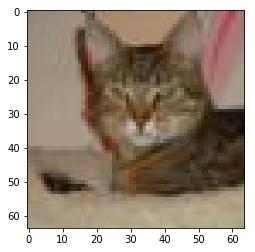

0


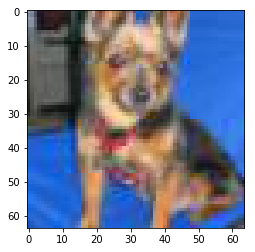

1


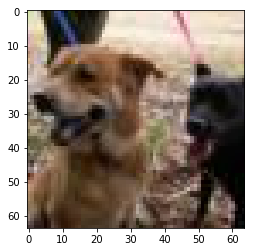

1


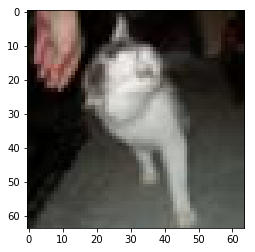

0


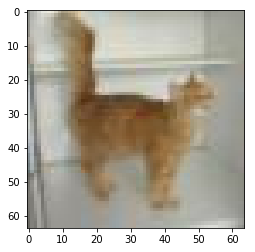

0


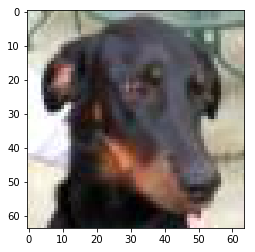

1


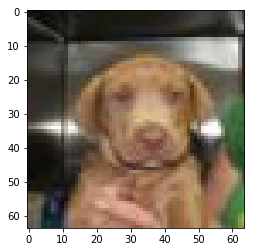

1


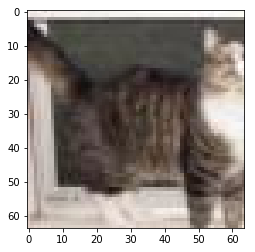

0


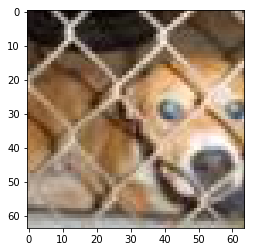

1


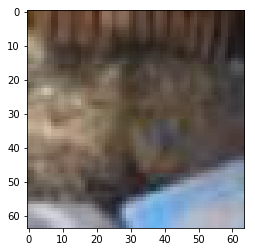

0


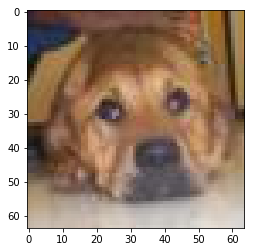

1


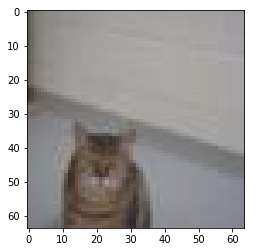

0


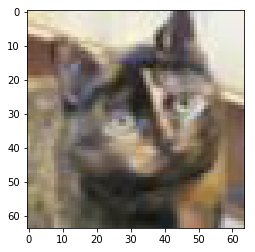

0


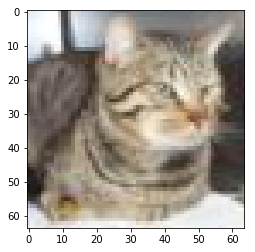

0


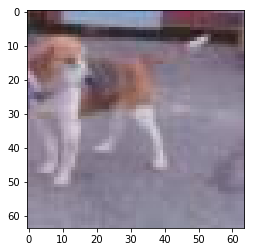

1


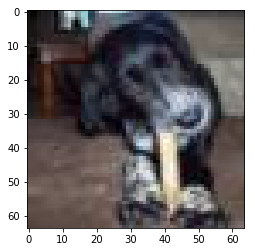

1


In [209]:
for i,j in enumerate(train_loader):
    if i%10000==1:
        x = j['image'].shape[0]
        for k in range(x):
            #print j['image']
            show_image(j['image'][k])
            print j['label'][k]

In [110]:
order = ['conv','pool','conv','pool','affine','affine']
conv_layers = [[16,3,1],[32,3,1]]
pool_layers = [[2,2],[2,2]]
affine_layers = [1000,2]
#self, order,conv_layer,pool_layers,fc_layers,loss_crit,dropout=0.5,batch_norm=False)
network = NeuralNet(order,conv_layers,pool_layers,affine_layers,nn.CrossEntropyLoss(),dropout=0.5,batch_norm=True)

In [111]:
#network.myparameters = network.myparameters.cuda()

In [ ]:
optimizer = torch.optim.Adam(network.myparameters,lr=0.0001)
network.train_model(dataset,optimizer,64,100,early_stopping=False,val_split=0.2)

Epoch : 1 Loss : 0.723  Train Accuracy: 0.512 Validation Accuracy: 0.517


In [214]:

data_loc = '../data/mnist/mnist.pkl'
data = np.load(data_loc)
mnist_train_data = data[0][0]
mnist_train_labels = data[0][1]

mnist_train_tensor = torch.utils.data.TensorDataset(torch.Tensor(mnist_train_data),torch.IntTensor(mnist_train_labels))

mnist_val_data = data[1][0]
mnist_val_labels = data[1][1]

mnist_val_tensor = torch.utils.data.TensorDataset(torch.Tensor(mnist_val_data),torch.IntTensor(mnist_val_labels))


mnist_test_data = data[2][0]
mnist_test_labels = data[2][1]

train_dataset = make_dataset(mnist_train_data, mnist_train_labels)
val_dataset = make_dataset(mnist_val_data,mnist_val_labels)
test_dataset = make_dataset(mnist_test_data,mnist_test_labels)


# Appendix

# A.1 Modified NeuralNet for testing on MNIST (sanity checks)

In [256]:
# params: conv_layers: a list of lists, containing the number of channels out[0], kernel size[1] and padding size[2]
#         pool_layers: a list of lists, each list contains the patch size[0] and stride [1]
#         fc_layers: a single list containing the number of hidden units in each layer
#         loss_crit: the loss criterion for the network - suggested BCE Loss
#         batch_norm: a boolean if True, adds batchnorm to every layer
class NeuralNet_MNIST(nn.Module):
    def __init__(self, conv_layer,pool_layers,fc_layers,loss_crit,batch_norm):
        super(NeuralNet_MNIST,self).__init__()
        self.loss_crit = loss_crit
        
        if len(conv_layer) != len(pool_layers):
            print "Number of convolution and pool layers don't match!"
            raise Exception('Convolutional and layer sizes dont match')
        self.num_conv_layers = len(conv_layer)
        self.conv_layers = [0]*self.num_conv_layers
        
        
        # Initial Convolution layer
        self.conv_layers[0] = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=conv_layer[0][0],
                      kernel_size=(conv_layer[0][1],conv_layer[0][1]),
                      padding=conv_layer[0][2]),
            nn.Dropout(0.5),
            nn.BatchNorm2d(conv_layer[0][0]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(pool_layers[0][0],pool_layers[0][0]),stride=pool_layers[0][1])
        )
        torch.nn.init.xavier_uniform(self.conv_layers[0][0].weight)
        torch.nn.init.constant(self.conv_layers[0][0].bias,0)
        outsize = (28-conv_layer[0][1]+2*conv_layer[0][2])/1 + 1
        outsize = (outsize-pool_layers[0][0])/pool_layers[0][1]+1
        
        #convolutional layers
        for i in range(1,self.num_conv_layers):
            self.conv_layers[i] = nn.Sequential(
                nn.Conv2d(in_channels=conv_layer[i-1][0], out_channels=conv_layer[i][0],
                          kernel_size=(conv_layer[i][1],conv_layer[i][1]),
                          padding=conv_layer[i][2]),
                nn.Dropout2d(0.5),
                nn.BatchNorm2d(conv_layer[i][0]),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(pool_layers[i][0],pool_layers[i][0]),stride=pool_layers[i][1])
            )
            torch.nn.init.xavier_uniform(self.conv_layers[i][0].weight)
            torch.nn.init.constant(self.conv_layers[i][0].bias,0)
            outsize = (outsize-conv_layer[i][1]+2*conv_layer[i][2])/1 + 1
            outsize = (outsize-pool_layers[i][0])/pool_layers[i][1]+1
            #self.myparameters.append(self.conv_layers[i].parameters())
        
        self.conv_output_size = conv_layer[i][0]*outsize*outsize
        print self.conv_output_size
        #affine layers
        self.num_affine_layers = len(fc_layers)
        self.affine_layers = [0]*len(fc_layers)
        self.affine_layers[0] = nn.Sequential(
            nn.Linear(self.conv_output_size,fc_layers[0]),
            nn.Dropout2d(0.5),
            nn.BatchNorm1d(fc_layers[0]),
            nn.ReLU()
        )
        torch.nn.init.xavier_uniform(self.affine_layers[0][0].weight)
        torch.nn.init.constant(self.affine_layers[0][0].bias,0)
        #self.myparameters.append(self.affine_layers[0].parameters())
        for i in range(1,len(fc_layers)):
            self.affine_layers[i] = nn.Sequential(
            nn.Linear(fc_layers[i-1],fc_layers[i]),
            nn.Dropout(0.5),
            nn.BatchNorm1d(fc_layers[i]),
            nn.ReLU()
        )
            torch.nn.init.xavier_uniform(self.affine_layers[i][0].weight)
            torch.nn.init.constant(self.affine_layers[i][0].bias,0)
            #self.myparameters.append(self.affine_layers[i].parameters())
        self.myparameters = []
        for i in range(len(self.conv_layers)):
            print type(self.conv_layers[i][0].bias)
            self.myparameters.append(self.conv_layers[i][0].weight)
            self.myparameters.append(self.conv_layers[i][0].bias)
        for i in range(len(self.affine_layers)):
            self.myparameters.append(self.affine_layers[i][0].weight)
            self.myparameters.append(self.affine_layers[i][0].bias)
        self.myparameters = nn.ParameterList(self.myparameters)
        

    def forward(self,x):
        layer_input = x
        for i in range(self.num_conv_layers):
            layer_output = self.conv_layers[i](layer_input)
            layer_input = layer_output
        
        for i in range(self.num_affine_layers):
            layer_output = self.affine_layers[i](layer_input.squeeze())
            layer_input = layer_output
        m = nn.Sigmoid()
        return m(layer_output)
    
    def evaluate_model(self,loader):
        correct = 0
        total = 0
        for batch_index, (inputs,targets) in enumerate(loader):
            inputs = Variable(inputs.view([-1,1,28,28]))
            targets = Variable(targets)

            logits = self.forward(inputs)
            _, preds = self.prediction(logits)
            correct += preds.eq(targets.data).sum()
            total += targets.size(0)
        accuracy = (correct/float(total))
        return accuracy
    
    def prediction(self,logits):
        
        values, indices = torch.max(logits.data,1)
        
        return values, indices

    def train_model(self, train_data,optimizer,batch_size, num_epochs,early_stopping=False, val_split = 0, test_data = None, verbose=True ):
        #prepare optimizer
        train_loader, val_loader, test_loader = make_data_loaders(train_data,batch_size,val_split,test_data)
        
        bestValAcc = 0
        bestNetwork = 0
        train_accuracy = []
        val_accuracy = []
        test_accuracy = []
        epoch_loss=[]
        l2_norms=[] 
        for epoch in range(num_epochs):
            losses = []
            correct = 0
            total = 0
            val_correct = 0
            val_total = 0
            test_correct = 0
            test_total = 0

            for batch_index, (inputs,targets) in enumerate(train_loader):
                inputs = Variable(inputs.view([-1,1,28,28]))
                targets = Variable(targets)

                logits = self.forward(inputs)
                _,preds = self.prediction(logits)

                correct += preds.eq(targets.data).sum()
                total += targets.size(0)
                
                loss = self.loss_crit(logits,targets)
                
                loss.backward()
                optimizer.step()
                losses.append(loss.data[0])
            epoch_loss.append(np.mean(losses))
            train_accuracy.append(correct/float(total))
            
            if (val_loader != None):
                val_acc = self.evaluate_model(val_loader)
                val_accuracy.append(val_acc)
                            
                if val_acc > bestValAcc:
                    bestNetwork = self
                    bestValAcc= val_acc
                
                if (early_stopping and val_acc < bestValAcc) :
                    return bestNetwork
            
            if (test_loader != None):
                test_acc = self.evaluate_model(test_loader)
                test_accuracy.append(test_acc)
            
            if (val_loader != None and test_loader != None and verbose == True):
                print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f Validation Accuracy: %.3f Test Accuracy: %.3f' % (epoch+1,epoch_loss[epoch],\
                                                                                                                  train_accuracy[epoch], val_accuracy[epoch], test_accuracy[epoch]))
            elif (val_loader != None and test_loader == None and verbose == True):
                print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f Validation Accuracy: %.3f' % (epoch+1,epoch_loss[epoch],\
                                                                                              train_accuracy[epoch], val_accuracy[epoch]))
            elif (verbose == True):
                print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f' %(epoch+1, epoch_loss[epoch], train_accuracy[epoch]))
        return (bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy,l2_norms)
    


In [257]:
conv_layers = [[16,3,1],[32,3,1],[64,3,1],[128,3,1]]
pool_layers = [[2,2],[2,2],[2,2],[2,2]]
affine_layers = [1000,10]
network2 = NeuralNet_MNIST(conv_layers,pool_layers,affine_layers,nn.CrossEntropyLoss(),batch_norm=True)

128
<class 'torch.nn.parameter.Parameter'>
<class 'torch.nn.parameter.Parameter'>
<class 'torch.nn.parameter.Parameter'>
<class 'torch.nn.parameter.Parameter'>


In [258]:
optimizer = torch.optim.Adam(network2.myparameters,lr=0.00001)
network2.train_model(train_dataset,optimizer,32,100,early_stopping=False,val_split=0.2)

Epoch : 1 Loss : 2.292  Train Accuracy: 0.143 Validation Accuracy: 0.187
Epoch : 2 Loss : 2.258  Train Accuracy: 0.237 Validation Accuracy: 0.293
Epoch : 3 Loss : 2.233  Train Accuracy: 0.321 Validation Accuracy: 0.341
Epoch : 4 Loss : 2.217  Train Accuracy: 0.367 Validation Accuracy: 0.364


Process Process-904:
Process Process-903:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/kyle/Downloads/yes/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/home/kyle/Downloads/yes/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/kyle/Downloads/yes/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/Downloads/yes/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kyle/Downloads/yes/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
  File "/home/kyle/Downloads/yes/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
    r = index_queue.get()
  File "/home/kyle/Downloads/yes/lib/python2.7/multiprocessing/queues.py", line 374, in ge

KeyboardInterrupt: 

    buf = self.recv_bytes()
KeyboardInterrupt


In [ ]:
  # Initial Convolution layer
        self.conv_layers[0] = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=conv_layer[0][0],
                      kernel_size=(conv_layer[0][1],conv_layer[0][1]),
                      padding=conv_layer[0][2]),
            nn.Dropout2d(dropout),
            nn.BatchNorm2d(conv_layer[0][0]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(pool_layers[0][0],pool_layers[0][0]),stride=pool_layers[0][1])
        )
        torch.nn.init.xavier_normal(self.conv_layers[0][0].weight)
        torch.nn.init.constant(self.conv_layers[0][0].bias,0)

        outsize = (64-conv_layer[0][1]+2*conv_layer[0][2])/1 + 1
        outsize = (outsize-pool_layers[0][0])/pool_layers[0][1]+1
        
        #convolutional layers
        for i in range(1,self.num_conv_layers):
            self.conv_layers[i] = nn.Sequential(
                nn.Conv2d(in_channels=conv_layer[i-1][0], out_channels=conv_layer[i][0],
                          kernel_size=(conv_layer[i][1],conv_layer[i][1]),
                          padding=conv_layer[i][2]),
                nn.Dropout2d(dropout),
                nn.BatchNorm2d(conv_layer[i][0]),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(pool_layers[i][0],pool_layers[i][0]),stride=pool_layers[i][1])
            )
            torch.nn.init.xavier_normal(self.conv_layers[i][0].weight)
            torch.nn.init.constant(self.conv_layers[i][0].bias,0)
            outsize = (outsize-conv_layer[i][1]+2*conv_layer[i][2])/1 + 1
            outsize = (outsize-pool_layers[i][0])/pool_layers[i][1]+1
            #self.myparameters.append(self.conv_layers[i].parameters())
        
        self.conv_output_size = conv_layer[i][0]*outsize*outsize
        print self.conv_output_size
        #affine layers
        self.num_affine_layers = len(fc_layers)
        self.affine_layers = [0]*len(fc_layers)
        self.affine_layers[0] = nn.Sequential(
            nn.Linear(self.conv_output_size,fc_layers[0]),
            nn.Dropout(0),
            nn.BatchNorm1d(fc_layers[0]),
            nn.ReLU()
        )
        torch.nn.init.xavier_normal(self.affine_layers[0][0].weight)
        torch.nn.init.constant(self.affine_layers[0][0].bias,0)
        #self.myparameters.append(self.affine_layers[0].parameters())
        for i in range(1,len(fc_layers)):
            self.affine_layers[i] = nn.Sequential(
            nn.Linear(fc_layers[i-1],fc_layers[i]),
            nn.Dropout(0),
            nn.BatchNorm1d(fc_layers[i]),
            nn.ReLU()
        )
            torch.nn.init.xavier_normal(self.affine_layers[i][0].weight)
            torch.nn.init.constant(self.affine_layers[i][0].bias,0)
            #self.myparameters.append(self.affine_layers[i].parameters())
        self.myparameters = []
        for i in range(len(self.conv_layers)):
            self.myparameters.append(self.conv_layers[i][0].weight)
            self.myparameters.append(self.conv_layers[i][0].bias)
            self.myparameters.append(self.conv_layers[i][2].weight)
            self.myparameters.append(self.conv_layers[i][2].bias)
        for i in range(len(self.affine_layers)):
            self.myparameters.append(self.affine_layers[i][0].weight)
            self.myparameters.append(self.affine_layers[i][0].bias)
            self.myparameters.append(self.affine_layers[i][2].weight)
            self.myparameters.append(self.affine_layers[i][2].bias)
        self.myparameters = nn.ParameterList(self.myparameters)
        
        if self.cuda_available:
            for i in range(len(self.conv_layers)):
                self.conv_layers[i][2].running_mean = self.conv_layers[i][2].running_mean.cuda()
                self.conv_layers[i][2].running_var = self.conv_layers[i][2].running_var.cuda()
            for i in range(len(self.affine_layers)):
                self.affine_layers[i][2].running_mean = self.affine_layers[i][2].running_mean.cuda()
                self.affine_layers[i][2].running_var = self.affine_layers[i][2].running_var.cuda()
        
    def print_types(self):
        for layer in self.conv_layers:
            print type(layer[0].weight)
    def forward(self,x):
        layer_input = x
        for i in range(self.num_conv_layers):
            layer_output = self.conv_layers[i](layer_input)
            layer_input = layer_output
        layer_input = layer_input.squeeze()
        for i in range(self.num_affine_layers):
            layer_output = self.affine_layers[i](layer_input)
            layer_input = layer_output
        #m = nn.Sigmoid()
        return layer_output
    
    def evaluate_model(self,loader):
        correct = 0
        total = 0
        for batch_index,(batch) in enumerate(loader):
            inputs = batch['image']
            targets = batch['label']
            if self.cuda_available:
                inputs = inputs.cuda()
                targets = targets.cuda()
            x, targets = Variable(inputs.view([-1,3,64,64])).float(), Variable(targets)

            logits = self.forward(x)
            preds = self.prediction(logits)
            correct += preds.eq(targets.data.int()).sum()
            total += targets.size(0)
        print correct
        print total
        accuracy = (correct/float(total))
        return accuracy
    
    def prediction(self,logits):
        
        _,preds = torch.max(logits.data,1)
        preds = preds.squeeze()
        preds = preds.int()
        return preds

    def train_model(self, train_data,optimizer,batch_size, num_epochs,early_stopping=False, val_split = 0, test_data = None, verbose=True ):

        train_loader, val_loader, test_loader = make_data_loaders(train_data,batch_size,val_split,test_data)
        
        bestValAcc = 0
        bestNetwork = 0
        train_accuracy = []
        val_accuracy = []
        test_accuracy = []
        epoch_loss=[]

        for epoch in range(num_epochs):
            losses = []
            correct = 0
            total = 0
            val_correct = 0
            val_total = 0
            test_correct = 0
            test_total = 0

            for index, batch in enumerate(train_loader):
                inputs = batch['image']
                targets = batch['label']
                if self.cuda_available:
                    inputs = inputs.cuda()
                    targets = targets.cuda()
                inputs = Variable(inputs.view([-1,3,64,64])).float()
                targets = Variable(targets)
                optimizer.zero_grad()
                logits = self.forward(inputs)
                preds = self.prediction(logits)
                correct += preds.eq(targets.data.int()).sum()
                total += targets.size(0)
                loss = self.loss_crit(logits,targets)
                
                loss.backward()
                optimizer.step()
                losses.append(loss.data[0])
            epoch_loss.append(np.mean(losses))
            train_accuracy.append(correct/float(total))
            
            if (val_loader != None):
                val_acc = self.evaluate_model(val_loader)
                val_accuracy.append(val_acc)
                            
                if val_acc > bestValAcc:
                    bestNetwork = self
                    bestValAcc= val_acc
                
                if (early_stopping and val_acc < bestValAcc) :
                    return bestNetwork
            
            if (test_loader != None):
                test_acc = self.evaluate_model(test_loader)
                test_accuracy.append(test_acc)
            
            if (val_loader != None and test_loader != None and verbose == True):
                print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f Validation Accuracy: %.3f Test Accuracy: %.3f' % (epoch+1,epoch_loss[epoch],\
                                                                                                                  train_accuracy[epoch], val_accuracy[epoch], test_accuracy[epoch]))
            elif (val_loader != None and test_loader == None and verbose == True):
                print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f Validation Accuracy: %.3f' % (epoch+1,epoch_loss[epoch],\
                                                                                              train_accuracy[epoch], val_accuracy[epoch]))
            elif (verbose == True):
                print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f' %(epoch+1, epoch_loss[epoch], train_accuracy[epoch]))
        return (bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy)
    
